In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [59]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [60]:

def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df

In [61]:
data = pd.read_csv('UPCOMI.csv')
data = convert_raw_data(data)
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,54.79,53.82,54.88,53.26,0.31K,1.80%
1,2010-01-05,54.45,55.05,55.22,54.07,0.36K,-0.62%
2,2010-01-06,54.22,54.35,54.56,52.97,0.36K,-0.42%
3,2010-01-07,53.33,54.18,54.80,53.21,0.28K,-1.64%
4,2010-01-08,51.82,52.98,53.27,51.60,0.24K,-2.83%
...,...,...,...,...,...,...,...
3479,2023-12-11,85.48,85.71,86.08,85.18,25.89K,-0.27%
3480,2023-12-12,85.35,85.49,85.68,85.06,23.24K,-0.15%
3481,2023-12-13,85.09,85.36,85.55,84.51,42.11K,-0.30%
3482,2023-12-14,85.22,85.06,85.54,84.83,27.43K,0.15%


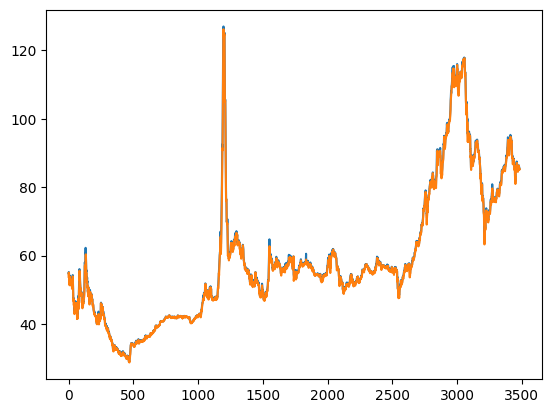

In [62]:
# gán biến
y = data[['Open']] # chuỗi thời gian cần dự báo (biến phụ thuộc)
X = data[['High']] # các biến độc lập



plt.plot(X)
plt.plot(y)
plt.show()

In [63]:
# chia train, test
ratio = 0.9

train_size = int(ratio * len(data))
test_size = int((1-ratio) * len(data))


train_data = data[:train_size]
test_data = data[train_size:]

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [64]:

svr_modal = SVR(kernel='rbf')
svr_modal.fit(X_train, y_train)



SVR()

In [65]:
# dự đoán giá đóng cửa của HNX trên tập kiểm tra

y_pred_sigmoid = svr_modal.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [66]:

mae = mean_absolute_error(y_test, y_pred_sigmoid)
mse = mean_squared_error(y_test, y_pred_sigmoid)
mape = mean_absolute_percentage_error(y_test, y_pred_sigmoid)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print('ratio', ratio)

MAE: 0.26904921766264933
MSE: 0.12764442105253154
RMSE: 0.35727359411595416
MAPE: 0.0033258145896483855
ratio 0.9


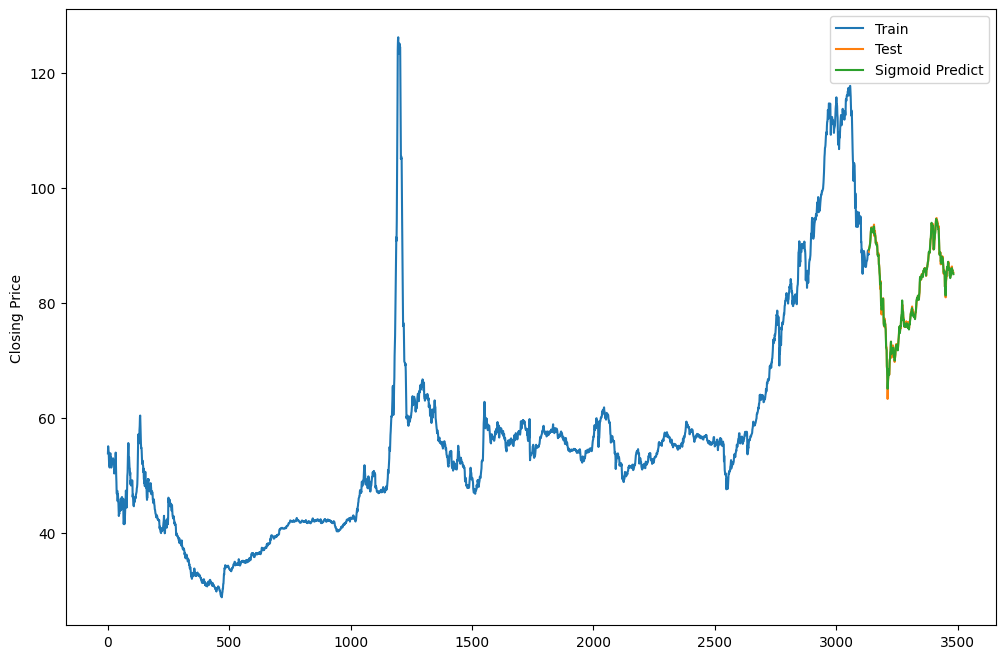

In [67]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [68]:
# láy giá trị Close của ngày cuối cùng trong dataset
last_row = data.tail(1)
last_data = last_row['Open'].values.reshape(-1,1)
last_data

array([[85.23]])

In [69]:
x_next_30_day_sigmoid = []

# predict giá Close 30 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(30):
    x_pred_next = svr_modal.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print(x_next_30_day_sigmoid)

[array([84.85597773]), array([84.47993786]), array([84.1007182]), array([83.71717908]), array([83.32819963]), array([82.93267607]), array([82.52952242]), array([82.11767397]), array([81.69609392]), array([81.26378367]), array([80.81979738]), array([80.36326113]), array([79.8933972]), array([79.40955365]), array([78.91123911]), array([78.39816205]), array([77.87027339]), array([77.32781008]), array([76.77133663]), array([76.20178022]), array([75.62045458]), array([75.02906706]), array([74.42970411]), array([73.82479154]), array([73.21702832]), array([72.60929637]), array([72.00455181]), array([71.405707]), array([70.81551397]), array([70.23646052])]


In [70]:
predicted_date = create_weekdays_december_january_dataframe()
# predicted_date['Date'] = pd.to
future_30_days_df = pd.DataFrame()
future_30_days_df["Open sigmoid"] = pd.DataFrame(np.concatenate(x_next_30_day_sigmoid), index=predicted_date["Date"], columns=["Open sigmoid"])

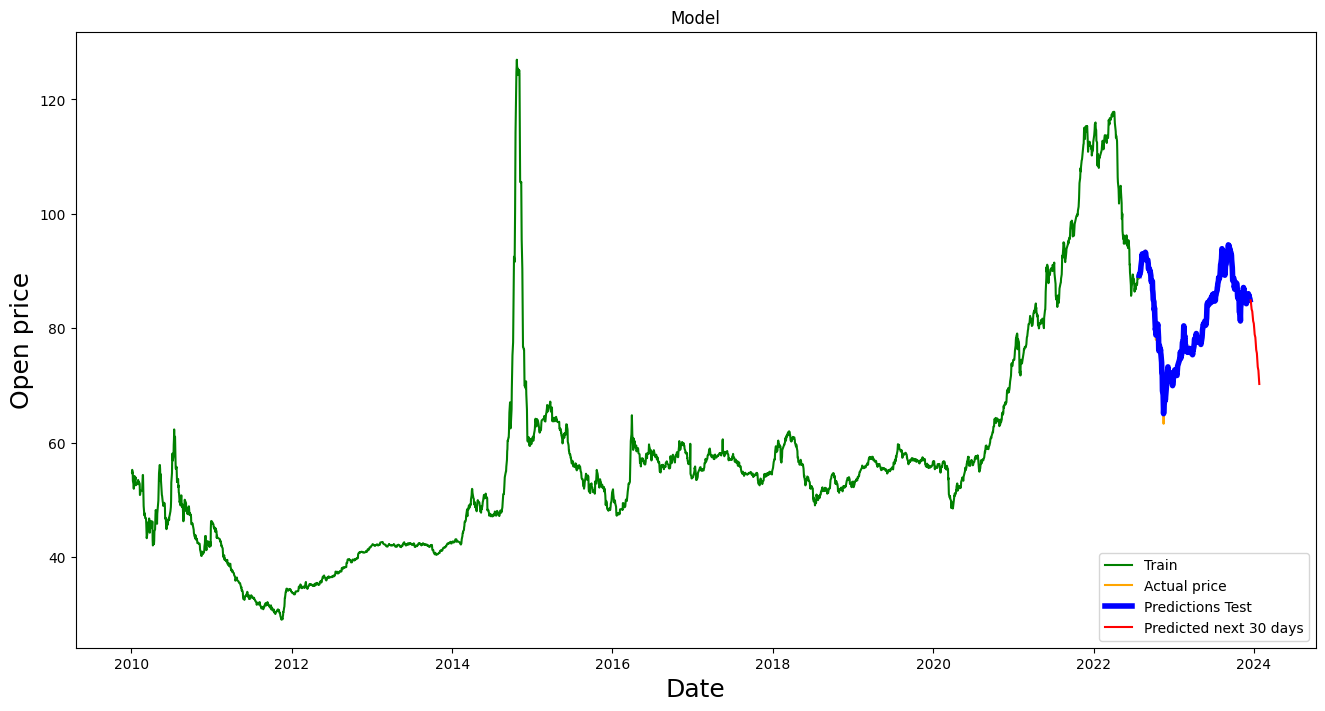

In [71]:
predicted_date = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(x_next_30_day_sigmoid, index=predicted_date["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price', fontsize=18)
plt.plot(train_data["Date"], X_train, color='green')
plt.plot(test_data["Date"], test_data["Open"], color='orange')
plt.plot(test_data["Date"],y_pred_sigmoid, color='blue', lw=4)
plt.plot(future_30_days_df.index, future_30_days_df['Open'], label='Predicted next 30 days', color = 'red')
plt.legend(['Train','Actual price', 'Predictions Test', 'Predicted next 30 days'], loc='lower right')
plt.show()